<a href="https://colab.research.google.com/github/tensorflow/tensorrt/blob/r2.0/tftrt/examples/image_classification/TFv2-TF-TRT-inference-from-Keras-saved-model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Copyright 2019 NVIDIA Corporation. All Rights Reserved.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
# ==============================================================================

<img src="http://developer.download.nvidia.com/compute/machine-learning/frameworks/nvidia_logo.png" style="width: 90px; float: right;">

# TensorFlow-TRT: Using Dynamic Shapes


## Introduction
The NVIDIA TensorRT is a C++ library that facilitates high performance inference on NVIDIA graphics processing units (GPUs). TensorRT takes a trained network, which consists of a network definition and a set of trained parameters, and produces a highly optimized runtime engine which performs inference for that network. 

TensorFlow™ integration with TensorRT™ (TF-TRT) optimizes and executes compatible subgraphs, allowing TensorFlow to execute the remaining graph. While you can still use TensorFlow's wide and flexible feature set, TensorRT will parse the model and apply optimizations to the portions of the graph wherever possible.

This notebook has the following sections:
1. [TL;DR Explanation](#1)
1. [Installing and checking dependencies](#2)
1. [Setting up the model](#3)
1. [Working with Dynamic shapes in TF-TRT](#4)

## TL;DR Explanation

## Installing and checking dependencies

### GPU

This demo will work on any NVIDIA GPU with CUDA cores, though for improved FP16 and INT8 inference, a Volta, Turing, Ampere or newer generation GPU with Tensor cores is desired.

In [2]:
!nvidia-smi

Wed Apr  6 21:56:19 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.57.02    Driver Version: 470.57.02    CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA Graphics...  On   | 00000000:01:00.0 Off |                    0 |
| 41%   60C    P0   107W / 200W |      0MiB / 47681MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

### Install Dependencies

In [3]:
!pip install pillow matplotlib

### Importing required libraries

In [4]:
from __future__ import absolute_import, division, print_function, unicode_literals
import os
import time

import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.python.compiler.tensorrt import trt_convert as trt
from tensorflow.python.saved_model import tag_constants
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions

In [5]:
 print("Tensorflow version: ", tf.version.VERSION)

# check TensorRT version
print("TensorRT version: ")
!dpkg -l | grep nvinfer

Tensorflow version:  2.8.0
TensorRT version: 
ii  libnvinfer-bin                    8.2.3-1+cuda11.4                  amd64        TensorRT binaries
ii  libnvinfer-dev                    8.2.3-1+cuda11.4                  amd64        TensorRT development libraries and headers
ii  libnvinfer-plugin-dev             8.2.3-1+cuda11.4                  amd64        TensorRT plugin libraries and headers
ii  libnvinfer-plugin8                8.2.3-1+cuda11.4                  amd64        TensorRT plugin library
ii  libnvinfer8                       8.2.3-1+cuda11.4                  amd64        TensorRT runtime libraries


A successfull TensorRT installation looks like:

```
TensorRT version: 
ii  libnvinfer5   5.1.5-1+cuda10.1   amd64        TensorRT runtime libraries
```

### Check Tensor core GPU
The below code check whether a Tensor-core GPU is present.

In [6]:
from tensorflow.python.client import device_lib

def check_tensor_core_gpu_present():
    local_device_protos = device_lib.list_local_devices()
    for line in local_device_protos:
        if "compute capability" in str(line):
            compute_capability = float(line.physical_device_desc.split("compute capability: ")[-1])
            if compute_capability>=7.0:
                return True
    
print("Tensor Core GPU Present:", check_tensor_core_gpu_present())
tensor_core_gpu = check_tensor_core_gpu_present()

Tensor Core GPU Present: True


2022-04-06 21:56:24.181641: I tensorflow/core/platform/cpu_feature_guard.cc:152] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE3 SSE4.1 SSE4.2 AVX
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-04-06 21:56:24.315566: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:952] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-06 21:56:24.377563: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:952] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-06 21:56:24.377832: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:952] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning

## Model

We next download and test a ResNet-50 pre-trained model from the Keras model zoo.

In [9]:
model = ResNet50(weights='imagenet')

2022-04-06 21:56:29.645825: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:952] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-06 21:56:29.646105: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:952] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-06 21:56:29.646262: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:952] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-06 21:56:29.646594: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:952] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-06 21:56:29.646755: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:952] successful NUMA node read from S

Before proceeding, let's quick take a look at the predictions

In [11]:
# Save the entire model as a SavedModel.
model.save('resnet50_saved_model') 

2022-04-06 21:56:39.020238: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: resnet50_saved_model/assets


In [12]:
!saved_model_cli show --all --dir resnet50_saved_model


MetaGraphDef with tag-set: 'serve' contains the following SignatureDefs:

signature_def['__saved_model_init_op']:
  The given SavedModel SignatureDef contains the following input(s):
  The given SavedModel SignatureDef contains the following output(s):
    outputs['__saved_model_init_op'] tensor_info:
        dtype: DT_INVALID
        shape: unknown_rank
        name: NoOp
  Method name is: 

signature_def['serving_default']:
  The given SavedModel SignatureDef contains the following input(s):
    inputs['input_1'] tensor_info:
        dtype: DT_FLOAT
        shape: (-1, 224, 224, 3)
        name: serving_default_input_1:0
  The given SavedModel SignatureDef contains the following output(s):
    outputs['predictions'] tensor_info:
        dtype: DT_FLOAT
        shape: (-1, 1000)
        name: StatefulPartitionedCall:0
  Method name is: tensorflow/serving/predict

Concrete Functions:
  Function Name: '__call__'
    Option #1
      Callable with:
        Argument #1
          inputs: T

TF-TRT takes input as aTensorFlow saved model, therefore, we re-export the Keras model as a TF saved model.

### Benchmarking Inference with native TF2.0 saved model

In [23]:
batch_size = 8
batched_input = np.zeros((batch_size, 224, 224, 3), dtype=np.float32)
batched_input = tf.constant(batched_input)
print('batched_input shape: ', batched_input.shape)

batched_input shape:  (8, 224, 224, 3)


In [24]:
# Benchmarking throughput
N_warmup_run = 50
N_run = 1000
elapsed_time = []

for i in range(N_warmup_run):
  preds = model.predict(batched_input)

for i in range(N_run):
  start_time = time.time()
  preds = model.predict(batched_input)
  end_time = time.time()
  elapsed_time = np.append(elapsed_time, end_time - start_time)
  if i % 50 == 0:
    print('Step {}: {:4.1f}ms'.format(i, (elapsed_time[-50:].mean()) * 1000))

print('Throughput: {:.0f} images/s'.format(N_run * batch_size / elapsed_time.sum()))

Step 0: 43.1ms
Step 50: 44.7ms
Step 100: 43.9ms
Step 150: 43.7ms
Step 200: 42.5ms
Step 250: 53.5ms
Step 300: 45.5ms
Step 350: 44.8ms
Step 400: 44.0ms
Step 450: 43.1ms
Step 500: 42.5ms
Step 550: 42.0ms
Step 600: 41.8ms
Step 650: 41.7ms
Step 700: 41.7ms
Step 750: 41.5ms
Step 800: 41.6ms
Step 850: 41.5ms
Step 900: 41.4ms
Step 950: 41.4ms
Throughput: 185 images/s


### TF-TRT FP32 model

We first convert the TF native FP32 model to a TF-TRT FP32 model.

In [16]:
print('Converting to TF-TRT FP32...')

converter = trt.TrtGraphConverterV2(input_saved_model_dir='resnet50_saved_model',
                                   precision_mode=trt.TrtPrecisionMode.FP32,
                                    max_workspace_size_bytes=8000000000)
converter.convert()
converter.save(output_saved_model_dir='resnet50_saved_model_TFTRT_FP32')
print('Done Converting to TF-TRT FP32')

Converting to TF-TRT FP32...
INFO:tensorflow:Linked TensorRT version: (8, 2, 3)
INFO:tensorflow:Loaded TensorRT version: (8, 2, 3)


2022-04-06 21:57:54.648891: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:952] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-06 21:57:54.649087: I tensorflow/core/grappler/devices.cc:66] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 1
2022-04-06 21:57:54.649165: I tensorflow/core/grappler/clusters/single_machine.cc:358] Starting new session
2022-04-06 21:57:54.649568: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:952] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-06 21:57:54.649761: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:952] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-06 21:57:54.649917: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:952] su

INFO:tensorflow:Could not find TRTEngineOp_0_0 in TF-TRT cache. This can happen if build() is not called, which means TensorRT engines will be built and cached at runtime.
INFO:tensorflow:Assets written to: resnet50_saved_model_TFTRT_FP32/assets
Done Converting to TF-TRT FP32


In [17]:
!saved_model_cli show --all --dir resnet50_saved_model_TFTRT_FP32


MetaGraphDef with tag-set: 'serve' contains the following SignatureDefs:

signature_def['__saved_model_init_op']:
  The given SavedModel SignatureDef contains the following input(s):
  The given SavedModel SignatureDef contains the following output(s):
    outputs['__saved_model_init_op'] tensor_info:
        dtype: DT_INVALID
        shape: unknown_rank
        name: NoOp
  Method name is: 

signature_def['serving_default']:
  The given SavedModel SignatureDef contains the following input(s):
    inputs['input_1'] tensor_info:
        dtype: DT_FLOAT
        shape: (-1, 224, 224, 3)
        name: serving_default_input_1:0
  The given SavedModel SignatureDef contains the following output(s):
    outputs['predictions'] tensor_info:
        dtype: DT_FLOAT
        shape: (-1, 1000)
        name: PartitionedCall:0
  Method name is: tensorflow/serving/predict

Concrete Functions:
  Function Name: '__call__'
    Option #1
      Callable with:
        Argument #1
          input_1: TensorSp

Before proceeding, let's write a couple of utility functions to use the model for prediction and benchmarking purposes.

In [18]:
def predict_tftrt(input_saved_model):
    """Runs prediction on a single image and shows the result.
    input_saved_model (string): Name of the input model stored in the current dir
    """
    img_path = './data/img0.JPG'  # Siberian_husky
    img = image.load_img(img_path, target_size=(224, 224))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    x = tf.constant(x)
    
    saved_model_loaded = tf.saved_model.load(input_saved_model, tags=[tag_constants.SERVING])
    signature_keys = list(saved_model_loaded.signatures.keys())
    print(signature_keys)

    infer = saved_model_loaded.signatures['serving_default']
    print(infer.structured_outputs)

    labeling = infer(x)
    preds = labeling['predictions'].numpy()
    print('{} - Predicted: {}'.format(img_path, decode_predictions(preds, top=3)[0]))
    plt.subplot(2,2,1)
    plt.imshow(img);
    plt.axis('off');
    plt.title(decode_predictions(preds, top=3)[0][0][1])

In [25]:
def benchmark_tftrt(input_saved_model,batched_input, batch_size):
    saved_model_loaded = tf.saved_model.load(input_saved_model, tags=[tag_constants.SERVING])
    infer = saved_model_loaded.signatures['serving_default']

    N_warmup_run = 50
    N_run = 1000
    elapsed_time = []

    for i in range(N_warmup_run):
      labeling = infer(batched_input)

    for i in range(N_run):
      start_time = time.time()
      labeling = infer(batched_input)
      end_time = time.time()
      elapsed_time = np.append(elapsed_time, end_time - start_time)
      if i % 50 == 0:
        print('Step {}: {:4.1f}ms'.format(i, (elapsed_time[-50:].mean()) * 1000))

    print('Throughput: {:.0f} images/s'.format(N_run * batch_size / elapsed_time.sum()))

['serving_default']
{'predictions': TensorSpec(shape=(None, 1000), dtype=tf.float32, name='predictions')}


2022-04-06 21:58:32.954219: I tensorflow/compiler/tf2tensorrt/kernels/trt_engine_op.cc:446] TRTEngineOp not using explicit QDQ
2022-04-06 21:58:32.959905: I tensorflow/compiler/tf2tensorrt/common/utils.cc:100] Linked TensorRT version: 8.2.3
2022-04-06 21:58:32.960022: I tensorflow/compiler/tf2tensorrt/common/utils.cc:102] Loaded TensorRT version: 8.2.3
2022-04-06 21:58:34.118186: I tensorflow/compiler/tf2tensorrt/convert/convert_nodes.cc:1372] [TF-TRT] Sparse compute capability is enabled.
2022-04-06 21:58:34.119278: W tensorflow/compiler/tf2tensorrt/utils/trt_logger.cc:36] TF-TRT Warning: DefaultLogger It is suggested to disable layer timing cache while using AlgorithmSelector. Please refer to the developer guide in https://docs.nvidia.com/deeplearning/tensorrt/developer-guide/index.html#builder-layer-timing.


./data/img0.JPG - Predicted: [('n02110185', 'Siberian_husky', 0.5574509), ('n02109961', 'Eskimo_dog', 0.416017), ('n02110063', 'malamute', 0.02126342)]


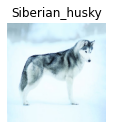

In [20]:
predict_tftrt('resnet50_saved_model_TFTRT_FP32')

In [21]:
benchmark_tftrt('resnet50_saved_model_TFTRT_FP32')

2022-04-06 21:59:18.288240: I tensorflow/compiler/tf2tensorrt/kernels/trt_engine_op.cc:446] TRTEngineOp not using explicit QDQ
2022-04-06 21:59:18.942325: W tensorflow/compiler/tf2tensorrt/utils/trt_logger.cc:36] TF-TRT Warning: DefaultLogger It is suggested to disable layer timing cache while using AlgorithmSelector. Please refer to the developer guide in https://docs.nvidia.com/deeplearning/tensorrt/developer-guide/index.html#builder-layer-timing.


Step 0:  2.0ms
Step 50:  2.0ms
Step 100:  1.9ms
Step 150:  1.9ms
Step 200:  1.9ms
Step 250:  1.9ms
Step 300:  1.9ms
Step 350:  1.9ms
Step 400:  1.9ms
Step 450:  2.2ms
Step 500:  1.9ms
Step 550:  1.9ms
Step 600:  1.9ms
Step 650:  1.9ms
Step 700:  1.9ms
Step 750:  1.9ms
Step 800:  1.9ms
Step 850:  1.9ms
Step 900:  1.9ms
Step 950:  1.9ms
Throughput: 4135 images/s


In [26]:
print('Converting to TF-TRT FP32...')

converter = trt.TrtGraphConverterV2(input_saved_model_dir='resnet50_saved_model',
                                   precision_mode=trt.TrtPrecisionMode.FP32,
                                    max_workspace_size_bytes=1<<33,
                                    maximum_cached_engines=2)
converter.convert()
converter.save(output_saved_model_dir='resnet50_saved_model_TFTRT_FP32')
print('Done Converting to TF-TRT FP32')

# The network has two input tensors. 
# We provide two sets of input shapes by input_fn.
# def input_fn():
#   input_shapes = [[(8, 224, 224, 3)],
#                   [(16, 224, 224, 3)],
#                   [(32, 224, 224, 3)]]
#   for shapes in input_shapes:
#     yield [np.zeros(x) for x in shapes]

# converter.build(input_fn)

Converting to TF-TRT FP32...
INFO:tensorflow:Linked TensorRT version: (8, 2, 3)
INFO:tensorflow:Loaded TensorRT version: (8, 2, 3)


2022-04-06 22:24:05.584034: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:952] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-06 22:24:05.584220: I tensorflow/core/grappler/devices.cc:66] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 1
2022-04-06 22:24:05.584305: I tensorflow/core/grappler/clusters/single_machine.cc:358] Starting new session
2022-04-06 22:24:05.584624: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:952] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-06 22:24:05.584793: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:952] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-06 22:24:05.584946: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:952] su

INFO:tensorflow:Could not find TRTEngineOp_2_0 in TF-TRT cache. This can happen if build() is not called, which means TensorRT engines will be built and cached at runtime.
INFO:tensorflow:Assets written to: resnet50_saved_model_TFTRT_FP32/assets
Done Converting to TF-TRT FP32


In [29]:
batch_size = 64
batched_input = np.zeros((batch_size, 224, 224, 3), dtype=np.float32)
batched_input = tf.constant(batched_input)
print('batched_input shape: ', batched_input.shape)

batched_input shape:  (64, 224, 224, 3)


In [30]:
benchmark_tftrt('resnet50_saved_model_TFTRT_FP32',batched_input,64)

2022-04-06 22:26:57.838384: I tensorflow/compiler/tf2tensorrt/kernels/trt_engine_op.cc:446] TRTEngineOp not using explicit QDQ
2022-04-06 22:26:58.494968: W tensorflow/compiler/tf2tensorrt/utils/trt_logger.cc:36] TF-TRT Warning: DefaultLogger It is suggested to disable layer timing cache while using AlgorithmSelector. Please refer to the developer guide in https://docs.nvidia.com/deeplearning/tensorrt/developer-guide/index.html#builder-layer-timing.


Step 0: 11.9ms
Step 50: 12.4ms
Step 100: 12.0ms
Step 150: 12.1ms
Step 200: 12.0ms
Step 250: 12.1ms
Step 300: 12.1ms
Step 350: 12.0ms
Step 400: 12.2ms
Step 450: 12.1ms
Step 500: 12.1ms
Step 550: 12.1ms
Step 600: 12.1ms
Step 650: 12.1ms
Step 700: 12.2ms
Step 750: 12.1ms
Step 800: 12.1ms
Step 850: 12.1ms
Step 900: 12.1ms
Step 950: 12.1ms
Throughput: 5286 images/s
